In [54]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from model import CustomDataset,MLP
from torch.utils.data import DataLoader
from data_preprocessing_revise import data_processing, split_train_test, input_target
from data_preprocessing_revise import input_target_grouping, input_target_grouping_1d
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import KFold
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from glob import glob
from tqdm import tqdm
import scipy.signal as signal
import time
import warnings
warnings.filterwarnings('ignore')
import copy

if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
    
print(device)

# 모델 인스턴스 생성
model = MLP()

cuda


In [75]:
file_list = [i.replace('\\','/') for i in sorted(glob(f"c3d/*txt"))]
file_name = []
for i in file_list:
    file, _, _ = os.path.basename(i).split('.')
    file_name.append(file)
    
FORCE, ANGLE, JOINT = data_processing(file_list, file_name)
player_trial, train, test = split_train_test(JOINT, random = 5)
DOM = {}
for session in JOINT:
    if session.split('_')[0] in test:
        df = JOINT[session]
        dominant = df['dominant'][0]
        DOM[session] = dominant

0it [00:00, ?it/s]

411it [00:15, 27.27it/s]


In [76]:
inputs_sc, targets = input_target(JOINT, FORCE, train, test,joint_cut_off = 13.4, force_cut_off = 60)
inputs_target_sc = {
    'train':{
        'lead' : {
            'input' : {},
            'target' : {},
            },
        'rear' : {
            'input' : {},
            'target' : {}},
    },
    'test':{
        'lead' : {
            'input' : {},
            'target' : {},
            },
        'rear' : {
            'input' : {},
            'target' : {}},
    }
}
for trial in targets['train']['lead']:
    idx = targets['train']['lead'][trial].index
    inputs_sc['train']['lead'][trial] = inputs_sc['train']['lead'][trial].loc[idx,:]
    inputs_target_sc['train']['lead']['input'][trial] = np.array(inputs_sc['train']['lead'][trial])
    inputs_target_sc['train']['lead']['target'][trial] = np.array(targets['train']['lead'][trial])
    
    idx = targets['train']['rear'][trial].index
    inputs_sc['train']['rear'][trial] = inputs_sc['train']['rear'][trial].loc[idx,:]
    inputs_target_sc['train']['rear']['input'][trial] = np.array(inputs_sc['train']['rear'][trial])
    inputs_target_sc['train']['rear']['target'][trial] = np.array(targets['train']['rear'][trial])
    
for trial in targets['test']['lead']:
    idx = targets['test']['lead'][trial].index
    inputs_sc['test']['lead'][trial] = inputs_sc['test']['lead'][trial].loc[idx,:].reset_index(drop=True)
    inputs_target_sc['test']['lead']['input'][trial] = np.array(inputs_sc['test']['lead'][trial])
    inputs_target_sc['test']['lead']['target'][trial] = np.array(targets['test']['lead'][trial])  
    
    idx = targets['test']['rear'][trial].index
    inputs_sc['test']['rear'][trial] = inputs_sc['test']['rear'][trial].loc[idx,:].reset_index(drop=True)
    inputs_target_sc['test']['rear']['input'][trial] = np.array(inputs_sc['test']['rear'][trial])
    inputs_target_sc['test']['rear']['target'][trial] = np.array(targets['test']['rear'][trial])

In [ ]:
import datetime


data_set_np = inputs_target_sc
data_set_name = 'standard'
epochs = 1000
learning_rate = 0.001

rear_time = 0
lead_time = 0
total_time_start = time.time()

k_fold_avg_score = {
    'lead' : {
        'r_x' : 0,
        'r_y' : 0,
        'r_z' : 0,
        'loss' : 0},
    
    'rear' : {
        'r_x' : 0,
        'r_y' : 0,
        'r_z' : 0,
        'loss' : 0},
}


for fp in ['lead','rear']:
    start = time.time()
    best_loss = float('inf')
    kfolds = KFold(n_splits=9, shuffle=True, random_state = 6)
    
    avg_r2_x = []
    avg_r2_y = []
    avg_r2_z = []
    avg_loss = []
    
    for fold, (t, v) in enumerate(kfolds.split(train)):
        if fold == 1:
            break
        tr = list(np.array(train)[t])
        va = list(np.array(train)[v])
        k_fold_since = time.time()
        train_sessions = list(inputs_sc['train'][fp])
        trn = []
        val = []
        for session in train_sessions:
            if session.split('_')[0] in tr:
                trn.append(session)
            elif session.split('_')[0] in va:
                val.append(session)
                
        train_dataset = {
            'x': torch.FloatTensor(np.concatenate([data_set_np['train'][fp]['input'][v] for v in trn], axis=0)), 
            'y': torch.FloatTensor(np.concatenate([data_set_np['train'][fp]['target'][v] for v in trn], axis=0))
            } 
        train_loader = DataLoader(CustomDataset(train_dataset['x'], train_dataset['y']), batch_size=32, shuffle=True)

        val_dataset = {
                        'x' : {v : torch.FloatTensor(data_set_np['train'][fp]['input'][v]) for v in val},
                        'y' : {v : torch.FloatTensor(data_set_np['train'][fp]['target'][v]) for v in val},    
                    }
        val_loader = {x : DataLoader(CustomDataset(val_dataset['x'][x], val_dataset['y'][x]), batch_size = len(val_dataset['x'][x])) for x in val}
        
        model = MLP().to(device)
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
        scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=3, verbose=True)
        
        k_fold_r2_x = 0
        k_fold_r2_y = 0
        k_fold_r2_z = 0
        k_fold_val_loss = float('inf')
        min_val_loss = float('inf')
        n_total_steps = len(train_loader)

        for epoch in range(epochs):
            total_train_loss = 0
            model.train()
            for i, (inputs, targets) in enumerate(train_loader):
                inputs = inputs.to(device)
                targets = targets.to(device)
                outputs = model(inputs)
                
                optimizer.zero_grad()
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()
                total_train_loss += loss.item()
            
            total_train_loss = total_train_loss/n_total_steps
            
            model.eval()
            val_r2 = []
            val_rmse = []
            val_losses = []
            val_N = len(val_loader)
            
            with torch.no_grad():
                for v in val_loader:
                    for inputs, targets in val_loader[v]:
                        inputs = inputs.to(device)
                        targets = targets.to(device)
                        outputs = model(inputs)
                        loss = criterion(outputs, targets)
                        val_losses.append(loss.item())
                        
                        r2_x = r2_score(targets.cpu()[:,0], outputs.cpu()[:,0])
                        r2_y = r2_score(targets.cpu()[:,1], outputs.cpu()[:,1])
                        r2_z = r2_score(targets.cpu()[:,2], outputs.cpu()[:,2])
                        val_r2.append(np.array([r2_x, 
                                                r2_y,
                                                r2_z,
                                                ]))
                             
            val_r2 = sum(val_r2)/val_N
            val_rmse = sum(val_rmse)/val_N
            val_loss = np.mean(val_losses)
            scheduler.step(val_loss)
            
            val_r2_x = val_r2[0]
            val_r2_y = val_r2[1]
            val_r2_z = val_r2[2]
            
            if (epoch+1) % 2 == 0: 
                print(f"Fold [{fold + 1}] | Epoch {epoch+1}/{epochs} | Train Loss: {total_train_loss:.4f} | Val Loss : {val_loss:.4f} | R2 : X = {val_r2_x:.4f}, Y = {val_r2_y:.4f}, Z = {val_r2_z:.4f}")
            
            if k_fold_val_loss > val_loss:
                k_fold_r2_x = val_r2_x
                k_fold_r2_y = val_r2_y
                k_fold_r2_z = val_r2_z
                k_fold_loss = val_loss
                
            if best_loss > val_loss:
                best_loss = val_loss
                best_model = copy.deepcopy(model)
                torch.save(model, f"model/MLP-re-{fp}-best-model.pt")
                torch.save(model.state_dict(), f'model/MLP-re-{fp}-best-model-parameters.pt')

            if val_loss < min_val_loss:
                min_val_loss = val_loss
                early_stop_count = 0
                
            else:
                early_stop_count += 1
            
            if early_stop_count >= 10:
                print(f"Early stopping | Fold [{fold + 1}] | Epoch {epoch+1}/{epochs}")
                break
        avg_r2_x.append(k_fold_r2_x)
        avg_r2_y.append(k_fold_r2_y)
        avg_r2_z.append(k_fold_r2_z)
        avg_loss.append(k_fold_loss)
        
    avg_r2_x = np.mean(avg_r2_x)
    avg_r2_y = np.mean(avg_r2_y)
    avg_r2_z = np.mean(avg_r2_z)
    avg_loss = np.mean(avg_loss)
    
    k_fold_avg_score[fp]['r_x'] = avg_r2_x
    k_fold_avg_score[fp]['r_y'] = avg_r2_y
    k_fold_avg_score[fp]['r_z'] = avg_r2_z
    k_fold_avg_score[fp]['loss'] = avg_loss
    
    end = time.time()
    sec = (end - start)
    result_list = str(datetime.timedelta(seconds=sec)).split(".")
    if fp == 'lead':
        lead_time = result_list[0]
    elif fp == 'rear':
        rear_time = result_list[0]

total_time_end = time.time()
total_sec = (total_time_end - total_time_start)
time_list = str(datetime.timedelta(seconds=total_sec)).split(".")

print(k_fold_avg_score)
print(f"total training time : {time_list[0]}")
print(f"lead training time : {lead_time}")
print(f"rear training time : {rear_time}")

Fold [1] | Epoch 2/1000 | Train Loss: 639.6374 | Val Loss : 352.0802 | R2 : X = 0.7126, Y = -0.9700, Z = 0.7529
Fold [1] | Epoch 4/1000 | Train Loss: 546.0481 | Val Loss : 300.0068 | R2 : X = 0.7284, Y = -0.4827, Z = 0.7818
Fold [1] | Epoch 6/1000 | Train Loss: 519.2870 | Val Loss : 311.2288 | R2 : X = 0.6918, Y = -0.1608, Z = 0.7703
Fold [1] | Epoch 8/1000 | Train Loss: 477.6953 | Val Loss : 303.8925 | R2 : X = 0.6941, Y = -0.1149, Z = 0.7680
Fold [1] | Epoch 10/1000 | Train Loss: 464.4668 | Val Loss : 347.5093 | R2 : X = 0.6602, Y = -0.1096, Z = 0.7214
Fold [1] | Epoch 12/1000 | Train Loss: 451.5021 | Val Loss : 319.6888 | R2 : X = 0.6774, Y = -0.0315, Z = 0.7504
Fold [1] | Epoch 14/1000 | Train Loss: 444.4508 | Val Loss : 298.3619 | R2 : X = 0.7093, Y = -0.0026, Z = 0.7741
Fold [1] | Epoch 16/1000 | Train Loss: 441.6118 | Val Loss : 311.3725 | R2 : X = 0.7043, Y = 0.0120, Z = 0.7575
Fold [1] | Epoch 18/1000 | Train Loss: 427.1901 | Val Loss : 306.0059 | R2 : X = 0.7039, Y = 0.0144, 

In [78]:
fp = 'lead'
kfolds = KFold(n_splits=9, shuffle=True, random_state=3)
for fold, (t, v) in enumerate(kfolds.split(train)):
    if fold == 1:
        break
    tr = list(np.array(train)[t])
    va = list(np.array(train)[v])
    k_fold_since = time.time()
    train_sessions = list(inputs_sc['train'][fp])
    trn = []
    val = []
    for session in train_sessions:
        if session.split('_')[0] in tr:
            trn.append(session)
        elif session.split('_')[0] in va:
            val.append(session)
            
test_sessions = []
for i in inputs_target_sc['test']['lead']['input']:
    if i.split('_')[0] in test:
        test_sessions.append(i)

In [ ]:
lead_model = torch.load(f'model/{model}-re-lead-best-model.pt', map_location=torch.device('cpu'))
lead_model.load_state_dict(torch.load(f'model/{model}-re-lead-best-model-parameters.pt', map_location=torch.device('cpu')))
rear_model = torch.load(f'model/{model}-re-rear-best-model.pt', map_location=torch.device('cpu'))
rear_model.load_state_dict(torch.load(f'model/{model}-re-rear-best-model-parameters.pt', map_location=torch.device('cpu')))

In [79]:
lead_test_dataset = {
                'x' : {v : torch.FloatTensor(inputs_target_sc['test']['lead']['input'][v]) for v in test_sessions},
                'y' : {v : torch.FloatTensor(inputs_target_sc['test']['lead']['target'][v]) for v in test_sessions},    
                }
lead_test_loader = {x : DataLoader(CustomDataset(lead_test_dataset['x'][x], lead_test_dataset['y'][x]), batch_size = len(lead_test_dataset['x'][x])) for x in test_sessions}

rear_test_dataset = {
                'x' : {v : torch.FloatTensor(inputs_target_sc['test']['rear']['input'][v]) for v in test_sessions},
                'y' : {v : torch.FloatTensor(inputs_target_sc['test']['rear']['target'][v]) for v in test_sessions},    
                }
rear_test_loader = {x : DataLoader(CustomDataset(rear_test_dataset['x'][x], rear_test_dataset['y'][x]), batch_size = len(rear_test_dataset['x'][x])) for x in test_sessions}

In [80]:
lead_y_true = {}
lead_y_pred = {}
rear_y_true = {}
rear_y_pred = {}
with torch.no_grad():
    lead_model.eval()
    rear_model.eval()
    for session in lead_test_loader:
        for inputs, targets in lead_test_loader[session]:
            lead_outputs = lead_model(inputs)
            lead_y_true[session] = pd.DataFrame(targets.numpy(), columns = ['AP Force','ML Force','Vertical Force'])
            lead_y_pred[session] = pd.DataFrame(lead_outputs.numpy(), columns = ['AP Force','ML Force','Vertical Force'])
    
    for session in rear_test_loader:
        for inputs, targets in rear_test_loader[session]:
            rear_outputs = rear_model(inputs)
            rear_y_true[session] = pd.DataFrame(targets.numpy(), columns = ['AP Force','ML Force','Vertical Force'])
            rear_y_pred[session] = pd.DataFrame(rear_outputs.numpy(), columns = ['AP Force','ML Force','Vertical Force'])

In [81]:
lead_tn_y_true = {}
lead_tn_y_pred = {}
lead_xr = []
lead_yr = []
lead_zr = []
lead_xrmse = []
lead_yrmse = []
lead_zrmse = []
lead_xnrmse = []
lead_ynrmse = []
lead_znrmse = []
smoothing = 1

import scipy.stats as stats
from tnorma import tnorma
for session in test_sessions:
    y_true = lead_y_true[session]
    y_pred = lead_y_pred[session]
    
    trn_y_true, b, a = tnorma(y_true,step=-101)
    lead_tn_y_true[session] = pd.DataFrame(trn_y_true, columns = y_true.columns)
    trn_y_pred, b, a = tnorma(y_pred,step=-101)
    lead_tn_y_pred[session] = pd.DataFrame(trn_y_pred, columns = y_pred.columns)
    
    lead_xr.append(stats.pearsonr(y_true['AP Force'], y_pred['AP Force'].ewm(span=smoothing).mean())[0])
    lead_yr.append(stats.pearsonr(y_true['ML Force'], y_pred['ML Force'].ewm(span=smoothing).mean())[0])
    lead_zr.append(stats.pearsonr(y_true['Vertical Force'], y_pred['Vertical Force'].ewm(span=smoothing).mean())[0])
    
    lead_xrmse.append(mean_squared_error(y_true['AP Force'], y_pred['AP Force'].ewm(span=smoothing).mean(),squared=False))
    lead_yrmse.append(mean_squared_error(y_true['ML Force'], y_pred['ML Force'].ewm(span=smoothing).mean(),squared=False))
    lead_zrmse.append(mean_squared_error(y_true['Vertical Force'], y_pred['Vertical Force'].ewm(span=smoothing).mean(),squared=False))
    
    lead_xnrmse.append(100 * mean_squared_error(y_true['AP Force'], y_pred['AP Force'].ewm(span=smoothing).mean(),squared=False) / (y_true['AP Force'].max() - y_true['AP Force'].min()))
    lead_ynrmse.append(100 * mean_squared_error(y_true['ML Force'], y_pred['ML Force'].ewm(span=smoothing).mean(),squared=False) / (y_true['ML Force'].max() - y_true['ML Force'].min()))
    lead_znrmse.append(100 * mean_squared_error(y_true['Vertical Force'], y_pred['Vertical Force'].ewm(span=smoothing).mean(),squared=False) / (y_true['Vertical Force'].max() - y_true['Vertical Force'].min()))
    
rear_tn_y_true = {}
rear_tn_y_pred = {}
rear_xr = []
rear_yr = []
rear_zr = []
rear_xrmse = []
rear_yrmse = []
rear_zrmse = []
rear_xnrmse = []
rear_ynrmse = []
rear_znrmse = []
smoothing = 1


for session in test_sessions:
    y_true = rear_y_true[session]
    y_pred = rear_y_pred[session]
    
    trn_y_true, b, a = tnorma(y_true,step=-101)
    rear_tn_y_true[session] = pd.DataFrame(trn_y_true, columns = y_true.columns)
    trn_y_pred, b, a = tnorma(y_pred,step=-101)
    rear_tn_y_pred[session] = pd.DataFrame(trn_y_pred, columns = y_pred.columns)
    
    rear_xr.append(stats.pearsonr(y_true['AP Force'], y_pred['AP Force'].ewm(span=smoothing).mean())[0])
    rear_yr.append(stats.pearsonr(y_true['ML Force'], y_pred['ML Force'].ewm(span=smoothing).mean())[0])
    rear_zr.append(stats.pearsonr(y_true['Vertical Force'], y_pred['Vertical Force'].ewm(span=smoothing).mean())[0])
    
    rear_xrmse.append(mean_squared_error(y_true['AP Force'], y_pred['AP Force'].ewm(span=smoothing).mean(),squared=False))
    rear_yrmse.append(mean_squared_error(y_true['ML Force'], y_pred['ML Force'].ewm(span=smoothing).mean(),squared=False))
    rear_zrmse.append(mean_squared_error(y_true['Vertical Force'], y_pred['Vertical Force'].ewm(span=smoothing).mean(),squared=False))
    
    rear_xnrmse.append(100 * mean_squared_error(y_true['AP Force'], y_pred['AP Force'].ewm(span=smoothing).mean(),squared=False) / (y_true['AP Force'].max() - y_true['AP Force'].min()))
    rear_ynrmse.append(100*mean_squared_error(y_true['ML Force'], y_pred['ML Force'].ewm(span=smoothing).mean(),squared=False) / (y_true['ML Force'].max() - y_true['ML Force'].min()))
    rear_znrmse.append(100*mean_squared_error(y_true['Vertical Force'], y_pred['Vertical Force'].ewm(span=smoothing).mean(),squared=False) / (y_true['Vertical Force'].max() - y_true['Vertical Force'].min()))
    

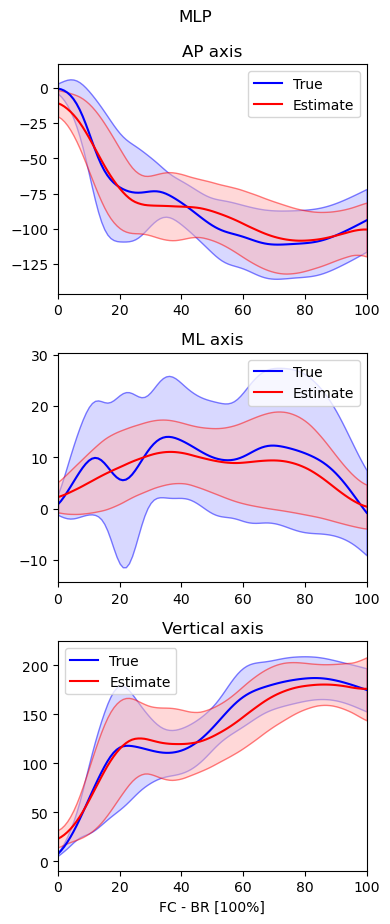

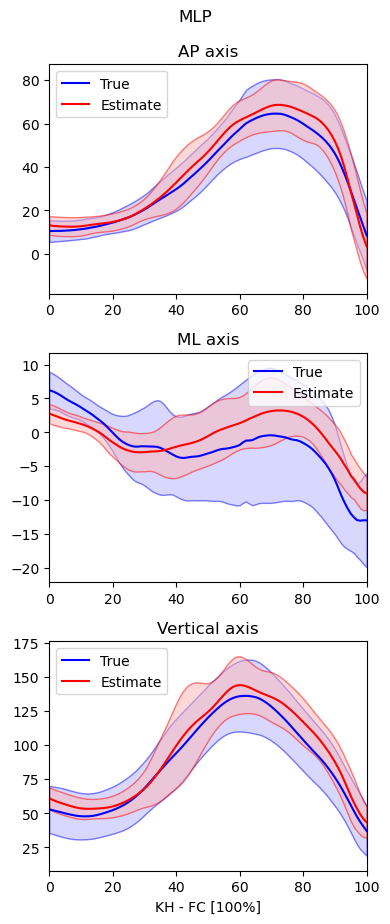

stride
X : RMSE 16.33 (6.51), NRMSE : 14.53 (5.98), R : 0.909 (0.080)
Y : RMSE 7.38 (3.67), NRMSE : 22.07 (6.31), R : 0.696 (0.260)
Z : RMSE 20.58 (8.62), NRMSE : 10.72 (3.78), R : 0.951 (0.038)
drive
X : RMSE 8.07 (4.27), NRMSE : 12.73 (8.56), R : 0.976 (0.017)
Y : RMSE 5.19 (3.43), NRMSE : 20.15 (11.29), R : 0.753 (0.277)
Z : RMSE 16.86 (16.73), NRMSE : 18.04 (22.50), R : 0.970 (0.030)


In [82]:
import spm1d
tn_pred = (np.concatenate([lead_tn_y_pred[session] for session in lead_tn_y_pred], axis=1)).T
tn_true = (np.concatenate([lead_tn_y_true[session] for session in lead_tn_y_true], axis=1)).T

fig, ax = plt.subplots(3,1, figsize= (4,9))
spm1d.plot.plot_mean_sd(tn_true[::3, :], linecolor='b', lw= 1.5,facecolor=(0.7,0.7,1), edgecolor='b', label='True', ax=ax[0])
spm1d.plot.plot_mean_sd(tn_pred[::3, :], linecolor='r', lw= 1.5, facecolor=(1,0.7,0.7), edgecolor='r', label='Estimate', ax=ax[0])
ax[0].legend()
ax[0].set_title('AP axis')
# ax[0].set_ylabel('% BW')
spm1d.plot.plot_mean_sd(tn_true[1::3, :], linecolor='b', lw= 1.5,facecolor=(0.7,0.7,1), edgecolor='b', label='True', ax=ax[1])
spm1d.plot.plot_mean_sd(tn_pred[1::3, :], linecolor='r', lw= 1.5, facecolor=(1,0.7,0.7), edgecolor='r', label='Estimate', ax=ax[1])
ax[1].legend()
ax[1].set_title('ML axis')
# ax[1].set_ylabel('% BW')
spm1d.plot.plot_mean_sd(tn_true[2::3, :], linecolor='b', lw= 1.5,facecolor=(0.7,0.7,1), edgecolor='b', label='True', ax=ax[2])
spm1d.plot.plot_mean_sd(tn_pred[2::3, :], linecolor='r', lw= 1.5, facecolor=(1,0.7,0.7), edgecolor='r', label='Estimate', ax=ax[2])
ax[2].legend()
ax[2].set_title('Vertical axis')
# ax[2].set_ylabel('% BW')
ax[2].set_xlabel('FC - BR [100%]')
plt.tight_layout()
plt.suptitle(f'{model}',y=1.022)
# plt.savefig(f'{model}_STRIDE.png',dpi=300,bbox_inches='tight')
plt.show()

tn_pred = (np.concatenate([rear_tn_y_pred[session] for session in rear_tn_y_pred], axis=1)).T
tn_true = (np.concatenate([rear_tn_y_true[session] for session in rear_tn_y_true], axis=1)).T
fig, ax = plt.subplots(3,1, figsize= (4,9))
spm1d.plot.plot_mean_sd(tn_true[::3, :], linecolor='b', lw= 1.5,facecolor=(0.7,0.7,1), edgecolor='b', label='True', ax=ax[0])
spm1d.plot.plot_mean_sd(tn_pred[::3, :], linecolor='r', lw= 1.5, facecolor=(1,0.7,0.7), edgecolor='r', label='Estimate', ax=ax[0])
ax[0].legend()
ax[0].set_title('AP axis')
# ax[0].set_ylabel('% BW')
spm1d.plot.plot_mean_sd(tn_true[1::3, :], linecolor='b', lw= 1.5,facecolor=(0.7,0.7,1), edgecolor='b', label='True', ax=ax[1])
spm1d.plot.plot_mean_sd(tn_pred[1::3, :], linecolor='r', lw= 1.5, facecolor=(1,0.7,0.7), edgecolor='r', label='Estimate', ax=ax[1])
ax[1].legend()
ax[1].set_title('ML axis')
# ax[1].set_ylabel('% BW')
spm1d.plot.plot_mean_sd(tn_true[2::3, :], linecolor='b', lw= 1.5,facecolor=(0.7,0.7,1), edgecolor='b', label='True', ax=ax[2])
spm1d.plot.plot_mean_sd(tn_pred[2::3, :], linecolor='r', lw= 1.5, facecolor=(1,0.7,0.7), edgecolor='r', label='Estimate', ax=ax[2])
ax[2].legend()
ax[2].set_title('Vertical axis')
# ax[2].set_ylabel('% BW')
ax[2].set_xlabel('KH - FC [100%]')
plt.tight_layout()
plt.suptitle(f'{model}',y=1.022)
# plt.savefig(f'{model}_DRIVE.png',dpi=300,bbox_inches='tight')
plt.show()

print('stride')
print(f"X : RMSE {np.mean(lead_xrmse):.2f} ({np.std(lead_xrmse):.2f}), NRMSE : {np.mean(lead_xnrmse):.2f} ({np.std(lead_xnrmse):.2f}), R : {np.mean(lead_xr):.3f} ({np.std(lead_xr):.3f})")
print(f"Y : RMSE {np.mean(lead_yrmse):.2f} ({np.std(lead_yrmse):.2f}), NRMSE : {np.mean(lead_ynrmse):.2f} ({np.std(lead_ynrmse):.2f}), R : {np.mean(lead_yr):.3f} ({np.std(lead_yr):.3f})")
print(f"Z : RMSE {np.mean(lead_zrmse):.2f} ({np.std(lead_zrmse):.2f}), NRMSE : {np.mean(lead_znrmse):.2f} ({np.std(lead_znrmse):.2f}), R : {np.mean(lead_zr):.3f} ({np.std(lead_zr):.3f})")
print('drive')
print(f"X : RMSE {np.mean(rear_xrmse):.2f} ({np.std(rear_xrmse):.2f}), NRMSE : {np.mean(rear_xnrmse):.2f} ({np.std(rear_xnrmse):.2f}), R : {np.mean(rear_xr):.3f} ({np.std(rear_xr):.3f})")
print(f"Y : RMSE {np.mean(rear_yrmse):.2f} ({np.std(rear_yrmse):.2f}), NRMSE : {np.mean(rear_ynrmse):.2f} ({np.std(rear_ynrmse):.2f}), R : {np.mean(rear_yr):.3f} ({np.std(rear_yr):.3f})")
print(f"Z : RMSE {np.mean(rear_zrmse):.2f} ({np.std(rear_zrmse):.2f}), NRMSE : {np.mean(rear_znrmse):.2f} ({np.std(rear_znrmse):.2f}), R : {np.mean(rear_zr):.3f} ({np.std(rear_zr):.3f})")